# Feature Selection

When you are done creating hundreds of thousands of features, it’s time for selecting a few of them. Well, we should never create hundreds of thousands of useless features. Having too many features pose a problem well known as the **curse of dimensionality.** If you have a lot of features, you must also have a lot of training samples to capture all the features. What’s considered a “lot” is not defined correctly and is up to you to figure out by validating your models properly and checking how much time it takes to train your models. 


The simplest form of selecting features would be to remove features with very low variance. If the features have a very low variance (i.e. very close to 0), they are close to being constant and thus, do not add any value to any model at all. It would just be nice to get rid of them and hence lower the complexity. Please note that the variance also depends on scaling of the data. Scikit-learn has an implementation for VarianceThreshold that does precisely this. 

In [ ]:
from sklearn.feature_selection import VarianceThreshold 

data =... 
var_thresh = VarianceThreshold(threshold=0.1) 
transformed_data = var_thresh.fit_transform(data)

#transformed data will have all columns with variance less 
#than 0.1 removed 

We can aslo remove features whcih have a high correlation. For calucalting the correation between differetn numiercal feautres, you can use the **Pearson correlation.**

In [10]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing 

#fetch a regression dataset 
data = fetch_california_housing() 
x = data["data"]

col_names = data["feature_names"]
y = data["target"]

#convert to pandas dataframe 
df = pd.DataFrame(x,columns = col_names)

#introduce a highly correlated column 
df.loc[:,"MedInc_Sqrt"] = df.MedInc.apply(np.sqrt)

#get correlation matrix(pearson)
df.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc_Sqrt
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.984329
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,-0.132797
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.326688
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.066910
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,0.018415
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,0.015266
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.084303
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.015569
MedInc_Sqrt,0.984329,-0.132797,0.326688,-0.066910,0.018415,0.015266,-0.084303,-0.015569,1.000000


In The above table we can see that the **MedIn_Sqrt** has a very correlation with *MedInc*. We can thus remove one of them.

And now we can move to some univariate ways of feature selection. **Univariate feature selection** is nothing but a scoring of each feature against a given target. **Mutual information, ANOVA F-test** and **chi2** are some of the most popular methods for univariate feature selection. There are two ways of using these in scikitlearn.  
*  SelectKBest: It keeps the top-k scoring features 
* SelectPercentile: It keeps the top features which are in a percentage specified by the user 

It must be noted that you can use chi2 only for data which is non-negative in nature. This is a particularly useful feature selection technique in natural language processing when we have a bag of words or tf-idf based features. It’s best to create a wrapper for univariate feature selection that you can use for almost any new problem.

In [15]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif 
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import mutual_info_regression 
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import SelectPercentile

class UnivariateFeatureSelction:
    
    def __init__(self, n_features, problem_type, scoring): 
        """
        Custom univariate feature selection wrapper on 
        different univariate feature selection models from 
        scikit-learn. :param n_features: SelectPercentile if float else 
        SelectKBest :param problem_type: classification or regression 
        :param scoring: scoring function, string """
        #for a given problem type, there are only 
        #a few valid scoring methods 
        #you can extend this with your own custom 
        #methods if you wish 
        if problem_type == "classification": 
            valid_scoring = { "f_classif": f_classif, "chi2": chi2, "mutual_info_classif": mutual_info_classif } 
        
        else:
            valid_scoring = { "f_regression": f_regression, "mutual_info_regression": mutual_info_regression } 
            
        #raise exception if we do not have a valid scoring method 
        if scoring not in valid_scoring:
            raise Exception("Invalid scoring function") 
            
        #if n_features is int, we use selectkbest 
        #if n_features is float, we use selectpercentile 
        #please note that it is int in both cases in sklearn 
        
        if isinstance(n_features, int):
            self.selection = SelectKBest( valid_scoring[scoring], 
                                         k=n_features) 
        
        elif isinstance(n_features, float): 
            
            self.selection = SelectPercentile( valid_scoring[scoring], percentile=int(n_features * 100) ) 
            
        else: 
            raise Exception("Invalid type of feature") 
            
    #same fit function
    def fit(self, X, y): 
        return self.selection.fit(X, y) 
    
    #same transform function 
    def transform(self, X):
        
        return self.selection.transform(X) 
    
    #same fit_transform function 
    def fit_transform(self, X, y): 
        
        return self.selection.fit_transform(X, y) 

In [17]:
ufs = UnivariateFeatureSelction( 
    n_features=0.1, 
    problem_type="regression", 
    scoring="f_regression" ) 

ufs.fit(x, y) 
X_transformed = ufs.transform(x) 

That should take care of most of your univariate feature selection needs. Please note that it’s usually better to create less and important features than to create hundreds of features in the first place. Univariate feature selection may not always perform well. Most of the time, people prefer doing feature selection using a machine learning model. Let’s see how that is done. 

The simplest form of feature selection that uses a model for selection is known as **greedy feature selection.** In greedy feature selection, 
* the first step is to choose a model. 
* The second step is to select a loss/scoring function. 
* And the third and final step is to iteratively evaluate each feature and add it to the list of “good” features if it improves loss/score. 

It can’t get simpler than this. But you must keep in mind that this is known as greedy feature selection for a reason. This feature selection process will fit a given model each time it evaluates a feature. The computational cost associated with this kind of method is very high. It will also take a lot of time for this kind of feature selection to finish. And if you do not use this feature selection properly, then you might even end up overfitting the model.
Let’s see how it works by looking at how its implemented. 


* The code for greedy algorithm is in **greedy.py** script and on running it we will get the following output.

<img src="../feature_sel1.png">


Figure 2 shows how this score improves with the addition of a new feature in every iteration. We see that we are not able to improve our score after a certain point, and that’s where we stop. 

<img src="../feature_sel.jpeg">


Another greedy approach is known as **recursive feature elimination (RFE)**. In the previous method, we started with one feature and kept adding new features, but in RFE, we start with all features and keep removing one feature in every iteration that provides the least value to a given model. But how to do we know which feature offers the least value? Well, if we use models like linear support vector machine (SVM) or logistic regression, we get a coefficient for each feature which decides the importance of the features. In case of any tree-based models, we get feature importance in place of coefficients. In each iteration, we can eliminate the least important features and keep eliminating it until we reach the number of features needed. So, we have the ability to decide how many features we want to keep.

When we are doing recursive feature elimination, in each iteration, we remove the feature which has the feature importance or the feature which has a coefficient close to 0. Please remember that when you use a model like logistic regression for binary classification, the coefficients for features are more positive if they are important for the positive class and more negative if they are important for the negative class. It’s very easy to modify our greedy feature selection class to create a new class for recursive feature elimination, but scikit-learn also provides RFE out of the box. 

* A simple usage is shown in **REF.py** script and on running the script the output is

<img src="../feature_sel2.png">


We saw two different greedy ways to select features from a model. But you can also fit the model to the data and select features from the model by the feature coefficients or the importance of features. If you use coefficients, you can select a threshold, and if the coefficient is above that threshold, you can keep the feature else eliminate it. Let’s see how we can get feature importance from a model like random forest. 

In [1]:
import pandas as pd 
from sklearn.datasets import load_diabetes 
from sklearn.ensemble import RandomForestRegressor 

#fetch a regression dataset 
#in diabetes data we predict diabetes progression 
#after one year based on some features 
data = load_diabetes() 
X = data["data"] 
col_names = data["feature_names"] 
y = data["target"] 

#initialize the model 
model = RandomForestRegressor() 

#fit the model 
model.fit(X, y) 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

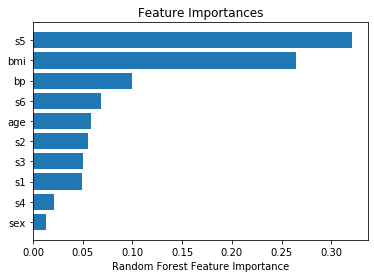

In [3]:
import matplotlib.pyplot as plt
import numpy as np
importances = model.feature_importances_ 
idxs = np.argsort(importances) 
plt.title('Feature Importances') 
plt.barh(range(len(idxs)), importances[idxs], align='center') 
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs]) 
plt.xlabel('Random Forest Feature Importance') 
plt.show() 

Well, selecting the best features from the model is nothing new. You can choose features from one model and use another model to train. For example, you can use Logistic Regression coefficients to select the features and then use Random Forest to train the model on chosen features. Scikit-learn also offers SelectFromModel class that helps you choose features directly from a given model. You can also specify the threshold for coefficients or feature importance if you want and the maximum number of features you want to select.

In [4]:
import pandas as pd 
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_selection import SelectFromModel 

#fetch a regression dataset 
#in diabetes data we predict diabetes progression 
#after one year based on some features 
data = load_diabetes() 

X = data["data"] 
col_names = data["feature_names"] 
y = data["target"] 

#initialize the model 
model = RandomForestRegressor() 

#select from the model
sfm = SelectFromModel(estimator=model) 
X_transformed = sfm.fit_transform(X, y) 
#see which features were selected 
support = sfm.get_support() 

#get feature names 
print([ x for x, y in zip(col_names, support) if y == True ]) 

['bmi', 's5']


Which prints: ['bmi', 's5']. When we look at figure 3, we see that these are the top- 2 features. Thus, we could have also selected directly from feature importance provided by random forest. 

One more thing that we are missing here is feature selection using models that have **L1 (Lasso) penalization**. When we have L1 penalization for regularization, most coefficients will be 0 (or close to 0), and we select the features with non-zero coefficients. You can do it by just replacing random forest in the snippet of selection from a model with a model that supports L1 penalty, e.g. lasso regression. All tree-based models provide feature importance so all the model-based snippets shown in this chapter can be used for XGBoost, LightGBM or CatBoost. The feature importance function names might be different and may produce results in a different format, but the usage will remain the same. In the end, you must be careful when doing feature selection. Select features on training data and validate the model on validation data for proper selection of features without overfitting the model.